# Language Model Fine-tuning

This notebook demonstrates fine-tuning a language model for a generation task.

<!-- Task: Given a name, generate its reverse (e.g., emma → amme) -->
Task: Given a news description, classify the dataset for a generation task

In [1]:
import os
import sys

hf_token = os.getenv("HF_TOKEN")

# Workaround for vscode on colab environments to prevent interactive token input
if 'google.colab' in sys.modules:
    # Mock the get function to return our token
    try:
        import google.colab.userdata
        original_get = google.colab.userdata.get
        
        def mock_get(key):
            if key == 'HF_TOKEN':
                return hf_token
            return original_get(key)
        
        google.colab.userdata.get = mock_get
        print("Patched Colab userdata to use environment token")
    except Exception as e:
        print(f"Could not patch Colab userdata: {e}")

Patched Colab userdata to use environment token


## The dataset

We loaded the "ag_news" dataset from Hugging Face. The "sh0416/ag_news" contains 3 columns, "title", "description" and "label" with labels being an integer 1-4 corresponding to 4 different classes, 1: World 2: Sports 3: Business 4: Sci/Tech. However, we also loaded the "ag_news" dataset which contained 2 columns, "label" and "text", with "text" values conveniently merging the news title and description in a single column. We decided to use the latter to provide more context to the model during fine tuning.

In [2]:
from datasets import load_dataset
# dataset = load_dataset("sh0416/ag_news")
dataset = load_dataset("ag_news")

## Load the model and tokenizer

In [3]:
import transformers
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "HuggingFaceTB/SmolLM2-135M"
# model_name = "facebook/opt-350m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Add special tokens
tokenizer.add_special_tokens({
    "pad_token": "<|pad|>",
    "bos_token": "<|startoftext|>",
})

# Resize embeddings to account for new tokens
# This call resizes the embedding matrix, initializes new rows randomly , and keeps old embeddings unchanged
model.resize_token_embeddings(len(tokenizer))

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 134,516,160


## Test the model before fine-tuning

In [4]:
# Get 5 random samples from the dataset
samples = dataset['train'].shuffle(seed=333).select(range(3))
for sample in samples:
    print(sample)

{'text': 'No Strawberries and Cream: Sharapova Ousted by Pierce Maria Sharapova suffered a harsh introduction Saturday to the expectations that will stalk her for the rest of her career. After a third-round loss at the US ', 'label': 1}
{'text': 'Bush, Kerry Forces Woo the Undecided (AP) AP - Put Barbara White down as undecided in the race for the White House.', 'label': 0}
{'text': 'Electronic Arts Gets an Exclusive NFL Deal The video game maker Electronic Arts announced an exclusive five-year deal with the National Football League and its players yesterday to design games using the NFL brand, stadiums, player names and uniforms.', 'label': 1}


In [5]:
print("Before fine-tuning:")
print("="*50)

for sample in samples:
    prompt = f"<|startoftext|>Classify the following news text: {sample['text']}. \nClass:"
    inputs = tokenizer(prompt, return_tensors="pt")

    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            max_new_tokens=20,
            temperature=1.0,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"{response}")
    print("-"*50)

Before fine-tuning:


Classify the following news text: No Strawberries and Cream: Sharapova Ousted by Pierce Maria Sharapova suffered a harsh introduction Saturday to the expectations that will stalk her for the rest of her career. After a third-round loss at the US . 
Class: Anecdote I heard: 
Anecdote: In a world, with which
--------------------------------------------------
Classify the following news text: Bush, Kerry Forces Woo the Undecided (AP) AP - Put Barbara White down as undecided in the race for the White House.. 
Class:  (Marks: 9)

I don't need to vote for these people,
--------------------------------------------------
Classify the following news text: Electronic Arts Gets an Exclusive NFL Deal The video game maker Electronic Arts announced an exclusive five-year deal with the National Football League and its players yesterday to design games using the NFL brand, stadiums, player names and uniforms.. 
Class: [J) [303] The world is not flat. And we have not seen any
--------------------------

## Create dataset

Format: `<|startoftext|>Reverse the name: emma. Answer: amme<|endoftext|>`

In [6]:
# import torch
# from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch

# Define the class mapping
class_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

class NewsClassificationDataset(Dataset):
    def __init__(self, dataset_split, tokenizer, max_length=256):
        self.data = dataset_split
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.class_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['text']
        label_num = item['label']
        label_text = self.class_names[label_num]
        
        # Create the training format: input text -> class name
        full_text = f"{self.tokenizer.bos_token}Classify the following news: {text}\nClass: {label_text}{self.tokenizer.eos_token}"
        prompt = f"{self.tokenizer.bos_token}Classify the following news: {text}\nClass:"
        
        return {
            'full_text': full_text,
            'prompt': prompt,
            'text': text,
            'label_text': label_text
        }

    def collate_fn(self, batch):
        full_texts = [item['full_text'] for item in batch]
        prompts = [item['prompt'] for item in batch]

        # Tokenize full texts
        tokenized = self.tokenizer(
            full_texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        # Create labels - copy input_ids but mask the prompt part
        labels = tokenized['input_ids'].clone()
        
        # Mask the prompt tokens in the labels (set to -100 so they're ignored in loss)
        for i, prompt in enumerate(prompts):
            prompt_tokens = self.tokenizer(prompt, add_special_tokens=False)['input_ids']
            prompt_len = len(prompt_tokens)
            if prompt_len < labels.shape[1]:
                labels[i, :prompt_len] = -100  # Ignore prompt tokens in loss calculation

        return {
            'input_ids': tokenized['input_ids'],
            'attention_mask': tokenized['attention_mask'],
            'labels': labels
        }

# Create datasets
original_train = dataset['train'].shuffle(seed=42)
split_data = original_train.train_test_split(test_size=0.3, seed=42)
train_data = split_data['train']
val_data = split_data['test']  # Note: train_test_split returns 'test' for the validation split

train_dataset = NewsClassificationDataset(train_data, tokenizer)
val_dataset = NewsClassificationDataset(val_data, tokenizer)
test_dataset = NewsClassificationDataset(dataset['test'], tokenizer)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=train_dataset.collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=val_dataset.collate_fn
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=test_dataset.collate_fn
)

# Verify the dataloaders work
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Example of how the data looks
sample_item = train_dataset[0]
print(f"\nSample training format:")
print(f"Full text: {sample_item['full_text']}")
print()
print(f"Prompt: {sample_item['prompt']}")
print()
print(f"Expected label: {sample_item['label_text']}")

# Check a batch
sample_batch = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"Input IDs: {sample_batch['input_ids'].shape}")
print(f"Labels: {sample_batch['labels'].shape}")
print(f"Attention mask: {sample_batch['attention_mask'].shape}")

Train batches: 5250
Val batches: 2250
Test batches: 475

Sample training format:
Full text: <|startoftext|>Classify the following news: Agents search Will County office in permit probe More than two dozen federal agents with subpoenas spent five hours Wednesday searching the Will County land use department #39;s computer records in an investigation related to building permits.
Class: Sci/Tech<|endoftext|>

Prompt: <|startoftext|>Classify the following news: Agents search Will County office in permit probe More than two dozen federal agents with subpoenas spent five hours Wednesday searching the Will County land use department #39;s computer records in an investigation related to building permits.
Class:

Expected label: Sci/Tech

Batch shapes:
Input IDs: torch.Size([16, 78])
Labels: torch.Size([16, 78])
Attention mask: torch.Size([16, 78])


## Examine a batch

In [7]:
# Look at a sample batch
sample_batch = next(iter(train_loader))
print("Sample batch shape:")
print(f"  input_ids: {sample_batch['input_ids'].shape}")
print(f"  attention_mask: {sample_batch['attention_mask'].shape}")
print(f"  labels: {sample_batch['labels'].shape}")

# Decode first example
print("\nFirst example:")
input_text = tokenizer.decode(sample_batch['input_ids'][0], skip_special_tokens=True)
print(f"Input: {input_text}")

# Show the labels (what the model should generate)
labels = sample_batch['labels'][0]
# Replace -100 with pad token for visualization
labels_viz = labels.clone()
labels_viz[labels_viz == -100] = tokenizer.pad_token_id
label_text = tokenizer.decode(labels_viz, skip_special_tokens=True)
print(f"Target (what model should generate): {label_text}")

# Show which tokens are ignored in loss (-100)
ignored_positions = (labels == -100).sum().item()
total_positions = labels.shape[0]
print(f"Tokens ignored in loss: {ignored_positions}/{total_positions}")
print(f"Tokens used for loss: {total_positions - ignored_positions}/{total_positions}")

Sample batch shape:
  input_ids: torch.Size([16, 82])
  attention_mask: torch.Size([16, 82])
  labels: torch.Size([16, 82])

First example:
Input: Classify the following news: Iran delays nuclear plant opening Iran says it has delayed plans to start up its first nuclear reactor by a year - but it plans to build more plants with Russian help.
Class: World
Target (what model should generate):  World
Tokens ignored in loss: 43/82
Tokens used for loss: 39/82


## Training loop

In [8]:
import torch.optim as optim
from tqdm import tqdm

learning_rate = 3e-5
num_epochs = 5
scale_factor = 1  # Scale factor to reduce training samples per epoch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
total_steps = len(train_loader) * num_epochs * scale_factor
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

print(f"Training on device: {device}")
print(f"Total training steps: {total_steps}")

# Add early stopping variables
best_val_loss = float('inf')
patience = 2
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, batch in enumerate(progress_bar):
        if batch_idx >= len(train_loader) * scale_factor:
            break  # Limit batches per epoch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Update progress bar
        if batch_idx % 50 == 0:
            avg_loss = total_loss / (batch_idx + 1)
            progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Average validation loss: {avg_val_loss:.4f}")
    print(f"  Learning rate: {scheduler.get_last_lr()[0]:.2e}")
    print("-" * 50)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("  New best model saved!")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{patience}")
        
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Training on device: cuda
Total training steps: 26250


Validation: 100%|██████████| 2250/2250 [02:56<00:00, 12.73it/s]



Epoch 1/5
  Average training loss: 0.0378
  Average validation loss: 0.0057
  Learning rate: 2.71e-05
--------------------------------------------------
  New best model saved!


Validation: 100%|██████████| 2250/2250 [03:02<00:00, 12.36it/s]



Epoch 2/5
  Average training loss: 0.0038
  Average validation loss: 0.0054
  Learning rate: 1.96e-05
--------------------------------------------------
  New best model saved!


Validation: 100%|██████████| 2250/2250 [03:01<00:00, 12.38it/s]



Epoch 3/5
  Average training loss: 0.0018
  Average validation loss: 0.0062
  Learning rate: 1.04e-05
--------------------------------------------------
  No improvement. Patience: 1/2


Validation: 100%|██████████| 2250/2250 [03:00<00:00, 12.49it/s]


Epoch 4/5
  Average training loss: 0.0006
  Average validation loss: 0.0081
  Learning rate: 2.86e-06
--------------------------------------------------
  No improvement. Patience: 2/2
Early stopping triggered!


## Generate and evaluate

In [13]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [14]:
def classify_news(model, tokenizer, text, device, max_new_tokens=10):
    """Generate classification for a news text"""
    prompt = f"{tokenizer.bos_token}Classify the following news: {text}\nClass:"
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=200).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            max_new_tokens=max_new_tokens,
            temperature=0.1, # Low temperature for more deterministic output
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    # Decode the full response
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract just the generated class
    if "Class:" in full_response:
        generated = full_response.split("Class:")[-1].strip()
        # Get just the first word (the class name)
        generated = generated.split()[0] if generated else ""
        return generated
    return ""

# Test on some examples
print("Testing classification after fine-tuning:")
print("="*70)

class_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
test_samples = dataset['test'].shuffle(seed=424).select(range(20))

correct = 0
total = 0

for sample in test_samples:
    text = sample['text']
    true_label = sample['label']
    true_class = class_names[true_label]
    
    generated_class = classify_news(model, tokenizer, text, device)
    
    is_correct = generated_class.lower() == true_class.lower()
    correct += is_correct
    total += 1
    
    symbol = "✓" if is_correct else "✗"
    
    print(f"Text: {text}")
    print(f"True class: {true_class}")
    print(f"Generated: {generated_class} {symbol}")
    print("-" * 70)

print(f"\nAccuracy: {correct}/{total} = {correct/total*100:.1f}%")

Testing classification after fine-tuning:
Text: Fresh violence mars Afghan vote count A deadly explosion has hit a car carrying an election worker in southeastern Afghanistan. In all, five people were killed, including the worker identified as a local physician who helped organize the vote.
True class: World
Generated: World ✓
----------------------------------------------------------------------


Text: Dominant US captures gold with 79th straight win The US softball team completed its scorched-earth run through the Olympics on Monday with a 5-1 win over Australia, America #39;s third straight gold medal.
True class: Sports
Generated: Sports ✓
----------------------------------------------------------------------
Text: GAO: Outsourcing could hurt IT employment growth A new GAO report indicates that offshore outsourcing could hurt IT employment growth over the next decade, but the study released today is sprinkled with caveats and qualifiers and shows more study is needed.
True class: Sci/Tech
Generated: Sci/Tech ✓
----------------------------------------------------------------------
Text: Afghan Militants Hold Talks on Hostages, but No Deal Yet Militants holding three foreign United Nations workers in Afghanistan said that they had held negotiations with officials from the Afghan government and the United 
True class: World
Generated: World ✓
-----------------------------------

## Evaluate on test set

Evaluating on test set...


Evaluating: 100%|██████████| 500/500 [01:03<00:00,  7.83it/s]



Overall Accuracy: 90.60%

Per-class accuracy:
  World: 91.7% (133 samples)
  Sports: 98.2% (112 samples)
  Business: 89.1% (137 samples)
  Sci/Tech: 83.9% (118 samples)


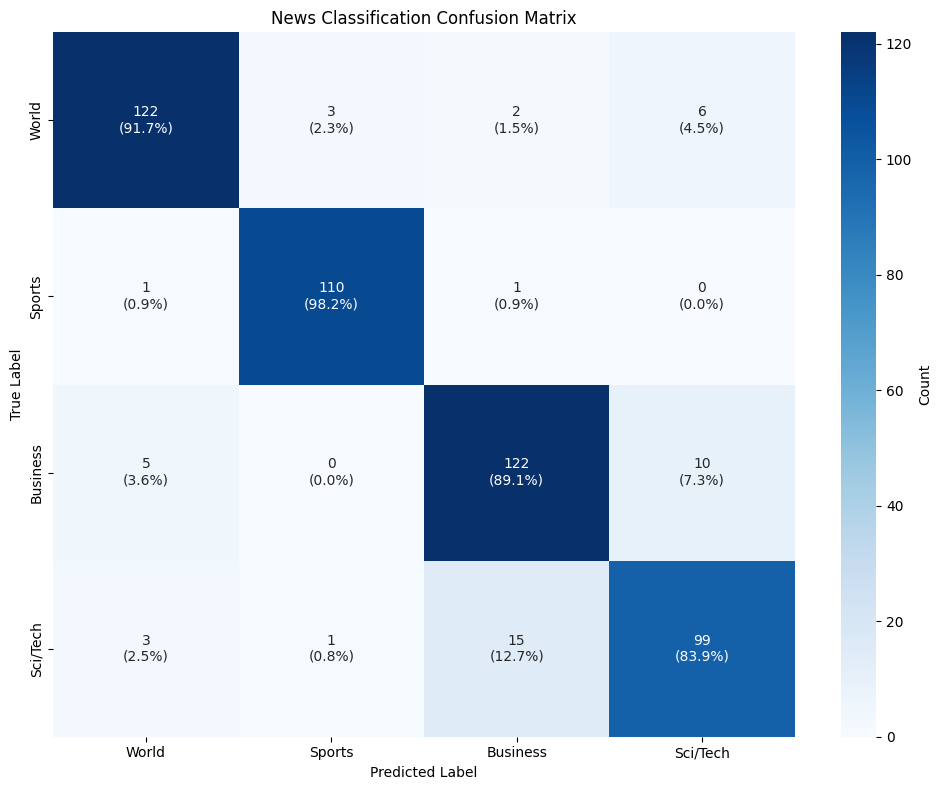


Classification Report:
              precision    recall  f1-score   support

       World       0.87      0.89      0.88       137
      Sports       0.86      0.84      0.85       118
    Business       0.96      0.98      0.97       112
    Sci/Tech       0.93      0.92      0.92       133

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500


Some examples of errors:
Text (first 100 chars) | True | Predicted
Bryant Makes First Appearance at Trial (AP) AP - NBA star Kobe Bryant arrived at his sexual assault trial Monday as attorneys in the case who spent the weekend ... | Sci/Tech | Sports
Vodafone targets Japan with 3G offensive Vodafone has unveiled plans for 10 new third-generation handsets for Christmas to help shore up its struggling Japanese... | Business | Sci/Tech
Apple offers 2004 financial details Apple's latest Form 10-K filing with the Securities and Exchange Co

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_classification_accuracy(model, tokenizer, test_dataset, device, sample_size=200):
    """Evaluate classification accuracy on test set and build confusion matrix."""
    
    class_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
    class_list = list(class_names.values())
    
    # Sample from test set - convert to list of indices and sample randomly
    total_samples = min(sample_size, len(test_dataset))
    indices = list(range(len(test_dataset)))
    import random
    random.seed(42)
    sampled_indices = random.sample(indices, total_samples)
    
    correct = 0
    errors = []
    class_correct = {name: 0 for name in class_names.values()}
    class_total = {name: 0 for name in class_names.values()}
    
    # Lists to store true and predicted labels for confusion matrix
    true_labels = []
    predicted_labels = []

    for i in tqdm(sampled_indices, desc="Evaluating"):
        sample = test_dataset[i]
        text = sample['text']
        true_label = sample['label'] 
        true_class = class_names[true_label]
        
        generated_class = classify_news(model, tokenizer, text[:300], device)
        
        # Store for confusion matrix
        true_labels.append(true_class)
        predicted_labels.append(generated_class)
        
        class_total[true_class] += 1
        
        if generated_class.lower() == true_class.lower():
            correct += 1
            class_correct[true_class] += 1
        else:
            errors.append((text[:160], true_class, generated_class))

    overall_accuracy = correct / total_samples
    
    # Calculate per-class accuracy
    class_accuracies = {}
    for class_name in class_names.values():
        if class_total[class_name] > 0:
            class_accuracies[class_name] = class_correct[class_name] / class_total[class_name]

    # Build confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_list)
    
    # Create classification report
    try:
        class_report = classification_report(true_labels, predicted_labels, 
                                           target_names=class_list, 
                                           zero_division=0)
    except:
        class_report = "Could not generate classification report"

    return {
        'overall_accuracy': overall_accuracy,
        'class_accuracies': class_accuracies,
        'class_counts': class_total,
        'errors': errors[:10],  # Show only first 10 errors
        'confusion_matrix': cm,
        'class_names': class_list,
        'true_labels': true_labels,
        'predicted_labels': predicted_labels,
        'classification_report': class_report
    }

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """Plot confusion matrix with percentages and counts."""
    plt.figure(figsize=(10, 8))
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with both count and percentage
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annotations[i, j] = f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)'
    
    # Plot heatmap
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Evaluate on test set
print("Evaluating on test set...")
results = evaluate_classification_accuracy(model, tokenizer, dataset['test'], device, sample_size=500)

print(f"\nOverall Accuracy: {results['overall_accuracy']*100:.2f}%")
print("\nPer-class accuracy:")
for class_name, accuracy in results['class_accuracies'].items():
    count = results['class_counts'][class_name]
    print(f"  {class_name}: {accuracy*100:.1f}% ({count} samples)")

# Plot confusion matrix
plot_confusion_matrix(results['confusion_matrix'], results['class_names'], 
                     'News Classification Confusion Matrix')

# Print classification report
print("\nClassification Report:")
print(results['classification_report'])

print(f"\nSome examples of errors:")
print("Text (first 100 chars) | True | Predicted")
print("="*60)
for text, true_class, predicted in results['errors']:
    print(f"{text}... | {true_class} | {predicted}")

## Test with different prompt formats

In [17]:
# Try different prompt variations to see if the model generalizes
test_prompts = [
    ("Classify the following news: {text}\nClass:", "Training Format"),
    ("What category is this news: {text}\nAnswer:", "Variation 1"),
    ("This news article is about: {text}\nCategory:", "Variation 2"),
    ("{text}\nTopic:", "Variation 3"),
]

# Get a test samples
test_samples = dataset['test'].shuffle(seed=424).select(range(5))
# test_text = test_sample['text'][:200]  # Limit text length
# true_label = test_sample['label']
class_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
expected_class = class_names[true_label]

print(f"Testing different prompts for news classification")
for test_sample in test_samples:
    test_text = test_sample['text']
    true_label = test_sample['label']
    expected_class = class_names[true_label]

    print(f"Text: {test_text[:100]}...")
    print(f"Expected class: {expected_class}")
    print("="*80)

    for prompt_template, prompt_type in test_prompts:
        prompt = tokenizer.bos_token + prompt_template.format(text=test_text)
        
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=300).to(device)
        
        model.eval()
        with torch.no_grad():
            outputs = model.generate(
                inputs["input_ids"],
                max_new_tokens=10,
                temperature=0.1,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )
        
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract the generated part
        prompt_text = prompt_template.format(text=test_text)
        if len(full_response) > len(prompt_text):
            generated = full_response[len(prompt_text):].strip()
            generated = generated.split()[0] if generated else ""
        else:
            generated = ""
        
        is_correct = generated.lower() == expected_class.lower()
        symbol = "✓" if is_correct else "✗"
        
        print(f"{prompt_type}:")
        print(f"  Generated: '{generated}' {symbol}")
        print()

Testing different prompts for news classification
Text: Fresh violence mars Afghan vote count A deadly explosion has hit a car carrying an election worker i...
Expected class: World
Training Format:
  Generated: 'World' ✓



Variation 1:
  Generated: 'World' ✓

Variation 2:
  Generated: 'World' ✓

Variation 3:
  Generated: 'World' ✓

Text: Dominant US captures gold with 79th straight win The US softball team completed its scorched-earth r...
Expected class: Sports
Training Format:
  Generated: 'Sports' ✓

Variation 1:
  Generated: 'Sports' ✓

Variation 2:
  Generated: 'Sports' ✓

Variation 3:
  Generated: 'Sports' ✓

Text: GAO: Outsourcing could hurt IT employment growth A new GAO report indicates that offshore outsourcin...
Expected class: Sci/Tech
Training Format:
  Generated: 'Sci/Tech' ✓

Variation 1:
  Generated: 'Sci/Tech' ✓

Variation 2:
  Generated: 'Sci/Tech' ✓

Variation 3:
  Generated: 'Sci/Tech' ✓

Text: Afghan Militants Hold Talks on Hostages, but No Deal Yet Militants holding three foreign United Nati...
Expected class: World
Training Format:
  Generated: 'World' ✓

Variation 1:
  Generated: 'World' ✓

Variation 2:
  Generated: 'World' ✓

Variation 3:
  Generated: 'World' ✓

Text: Techs lead 

## Discusion

Se implementó un modelo de lenguaje basado en SmolLM2-135M (135 millones de parámetros) para clasificar titulares y descripciones del dataset AG News. Aunque su tamaño limitado puede restringir su capacidad para capturar matices lingüísticos complejos, resultó suficiente para esta tarea específica, ofreciendo un equilibrio entre rendimiento y recursos computacionales. En lugar de usar una capa clasificadora tradicional, se aplicó fine-tuning generativo: el modelo aprende a generar directamente la etiqueta de clase a partir del texto de entrada.

La implementación incluyó un dataset estructurado mediante la clase NewsClassificationDataset, que incorporó prompts formateados, tokenización con tokens especiales (<|startoftext|> y ``) y masking de tokens del prompt mediante el valor -100 en las etiquetas. Esta técnica garantiza que la función de pérdida solo considere la generación de la etiqueta, no la repetición del prompt, lo cual es clave para el entrenamiento eficaz en este enfoque generativo.

Durante el entrenamiento, el modelo mostró tendencia al sobreajuste incluso tras pocas épocas. Para mitigarlo, se aplicaron estrategias como early stopping con paciencia de 2 épocas, reducción del learning rate inicial y ajuste de la temperatura de generación (mejor desempeño con valores bajos). Estas medidas lograron estabilizar el entrenamiento y mejorar la generalización.

La evaluación, realizada sobre 500 muestras del conjunto de prueba, incluyó métricas cuantitativas (matriz de confusión, reporte de clasificación, accuracy por clase) y pruebas de robustez con distintos formatos de prompt, demostrando cierta capacidad de generalización. No obstante, el tamaño reducido del modelo limita su habilidad para manejar contextos lingüísticos complejos, lo que afecta su precisión en casos ambiguos o sutiles.

Un aspecto particularmente interesante de los resultados es la evaluación de robustez mediante diferentes formatos de prompt. Esta experimentación revela la capacidad del modelo para generalizar más allá del formato exacto de entrenamiento. También, notamos que hay una confusión entre las categorías de Business y Sci/Tech en la matriz de confusión, que luego de inspeccionar algunas de las muestras erroneas se denotan ciertos términos que podrían corresponder a la categoría de la predicción. En algunos casos, incluso para un humano, clasificarlo correctamente podría ser un poco confuso sin un contexto más detallado acerca de la noticia.

## Conclusion

El trabajo concluye que el fine-tuning de modelos pequeños es viable para tareas específicas de clasificación, especialmente en entornos con recursos limitados. Sin embargo, se identifican oportunidades de mejora: data augmentation textual (paraphrasing, reemplazo de sinónimos, back-translation), técnicas de PEFT, curriculum learning, optimización sistemática de hiperparámetros y evaluación comparativa con modelos más grandes o enfoques tradicionales. Estas líneas futuras podrían potenciar tanto el rendimiento como la eficiencia del enfoque propuesto.
